In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
data_dir = '/Users/mik/Desktop/med_wrench_calibration'

In [3]:
data_dir_name = data_dir.split('/')[-1]
dl_path = os.path.join(data_dir, '{}_DataLegend.csv'.format(data_dir_name))

data_legend = pd.read_csv(dl_path)

In [4]:
data_legend

,Time,Sequence,SequenceIndx,FileCode,JointState
0,1.631916e+09,0,0,1,"(-0.5197337232439726, 0.6333683834725395, -0.0..."
1,1.631916e+09,0,1,2,"(-0.5481052971638078, 0.5004802870070483, -0.0..."
2,1.631916e+09,0,2,3,"(-0.5337389079507585, 0.40026166686961034, -0...."
3,1.631916e+09,0,3,4,"(-0.445305814264633, 0.7750007697314109, -0.08..."
4,1.631916e+09,0,4,5,"(-0.4647847338418624, 0.6678783971996157, -0.0..."
...,...,...,...,...,...
751,1.631920e+09,7,76,752,"(-0.4555402225401345, 0.6483255351123793, -0.0..."
752,1.631920e+09,7,77,753,"(-0.43284018307295125, 0.7930185725263669, -0...."
753,1.631920e+09,7,78,754,"(-0.5591304844527907, 0.4073626796485202, -0.0..."
754,1.631920e+09,7,79,755,"(-0.5301782149471242, 0.4972814576987194, -0.0..."


In [5]:
def load_wrench(fc, scene_name):
    wrench_dir = os.path.join(data_dir, scene_name, 'wrenches')
    wrench_file_path = os.path.join(wrench_dir, '{}_wrench_{:06}.csv'.format(scene_name, fc))
    wrench_df = pd.read_csv(wrench_file_path)
    return wrench_df

def load_tfs(fc, scene_name):
    tfs_dir = os.path.join(data_dir, scene_name, 'tfs')
    tfs_file_path = os.path.join(tfs_dir, 'recorded_tfs_{:06}.csv'.format(fc))
    tfs_df = pd.read_csv(tfs_file_path)
    return tfs_df

In [6]:
load_wrench(1, 'wrench_scene')

,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,wrench.force.x,wrench.force.y,wrench.force.z,wrench.torque.x,wrench.torque.y,wrench.torque.z
0,28912,0,0,med_kuka_link_ee,0.335528,1.871953,2.117695,0.299955,-0.317319,0.437285
1,0,0,0,grasp_frame,-1.871954,0.335521,2.117695,0.317318,0.299956,0.437285
2,0,1631916401,579798698,med_base,-0.364997,1.851126,-2.131086,-0.309339,-0.320433,-0.428386


In [7]:
load_tfs(1,'wrench_scene')

,Unnamed: 0,parent_frame,child_frame,x,y,z,qx,qy,qz,qw
0,0,med_base,grasp_frame,0.449796,-0.300869,0.100767,0.705357,-0.708775,-0.002654,0.010152
1,1,med_base,med_kuka_link_ee,0.453495,-0.298715,0.304722,-0.002418,-0.999942,0.005302,0.009055


In [139]:
def load_data(ref_frame='med_kuka_link_ee'):
    filecodes = data_legend['FileCode']
    scene_name = 'wrench_scene'
    all_data = []
    tfs_columns = ['parent_frame', 'child_frame', 'x', 'y', 'z', 'qx', 'qy', 'qz', 'qw']
    wrench_columns = ['wrench.force.x', 'wrench.force.y', 'wrench.force.z', 'wrench.torque.x', 'wrench.torque.y', 'wrench.torque.z']
    data_columns = ['fc'] + tfs_columns + wrench_columns 
    for i, fc in enumerate(tqdm(filecodes)):
        sequence_i = data_legend['Sequence'][i]
        sequence_indx_i = data_legend['SequenceIndx'][i]
        time_i = data_legend['Time'][i]
        wrenches_i = load_wrench(fc, scene_name)
        tfs_i = load_tfs(fc, scene_name)
        tf_i = tfs_i.loc[tfs_i['child_frame'] == ref_frame]
        wrench_i = wrenches_i.loc[wrenches_i['header.frame_id'] == ref_frame]
        tf_data_i = tf_i[tfs_columns].reset_index(drop=True)
        wrench_data_i = wrench_i[wrench_columns].reset_index(drop=True)
#         import pdb; pdb.set_trace()
        data_i = pd.concat([tf_data_i,wrench_data_i],axis=1)
        data_i['FileCode'] = fc
        data_i['Sequence'] = sequence_i
        data_i['SequenceIndx'] = sequence_indx_i
        data_i['Time'] = time_i
        all_data.append(data_i)
    df = pd.concat(all_data, ignore_index=True)
    wrapped_indxs = df['SequenceIndx'] % (27*2)
    mask = wrapped_indxs//27
    df['PositionIndx'] = wrapped_indxs * ((-1)*(mask-1)) + mask*(27*2-1-wrapped_indxs)
    return df
        
        
        
    

In [140]:
all_data = load_data()

100%|██████████| 756/756 [00:04<00:00, 166.90it/s]


In [125]:
_xs = np.arange(10)
xs = np.concatenate([_xs,_xs])
xs

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [126]:
xs % 10

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [131]:
mask = (xs//5)*2

final_xs = xs * ((-1)*(mask-1)) + mask*(9-xs)
final_xs

array([0, 1, 2, 3, 4, 4, 3, 2, 1, 0, 0, 1, 2, 3, 4, 4, 3, 2, 1, 0])

In [145]:
all_data[150:200]

,parent_frame,child_frame,x,y,z,qx,qy,qz,qw,wrench.force.x,wrench.force.y,wrench.force.z,wrench.torque.x,wrench.torque.y,wrench.torque.z,FileCode,Sequence,SequenceIndx,Time,PositionIndx
150,med_base,med_kuka_link_ee,0.452322,0.001761,0.502855,-0.000056,-0.999961,0.005840,0.006582,-1.617322,-0.397988,3.555042,-0.481049,-0.099709,-0.088265,151,2,42,1.631917e+09,11
151,med_base,med_kuka_link_ee,0.451209,0.004947,0.403213,0.006948,-0.999925,0.009137,0.004165,0.231867,-0.095705,1.457982,-0.469943,-0.129983,-0.162893,152,2,43,1.631917e+09,10
152,med_base,med_kuka_link_ee,0.451287,-0.002927,0.304783,-0.007746,-0.999944,-0.007151,0.001001,-0.473793,1.609021,1.840768,0.526128,0.083635,0.284320,153,2,44,1.631917e+09,9
153,med_base,med_kuka_link_ee,0.645704,-0.303769,0.505627,0.003296,0.999929,0.007558,0.008594,2.655083,2.476822,3.817074,0.051091,-0.691852,0.423690,154,2,45,1.631917e+09,8
154,med_base,med_kuka_link_ee,0.645809,-0.294804,0.403539,-0.004101,0.999906,-0.009735,0.008721,-1.236824,-0.289516,2.873303,-0.423491,-0.083848,0.350066,155,2,46,1.631917e+09,7
155,med_base,med_kuka_link_ee,0.652437,-0.297469,0.303093,-0.005273,0.999958,-0.004018,-0.006301,-0.831887,0.009433,2.638257,-0.289447,-0.097946,0.268302,156,2,47,1.631917e+09,6
156,med_base,med_kuka_link_ee,0.548825,-0.297941,0.503600,0.003441,0.999955,-0.004640,0.007574,-1.478061,0.241321,3.333486,-0.093490,-0.201495,0.555434,157,2,48,1.631917e+09,5
157,med_base,med_kuka_link_ee,0.544076,-0.297256,0.403836,-0.007089,0.999903,-0.007126,0.009659,0.596469,0.628371,2.219952,-0.225759,-0.422491,0.328445,158,2,49,1.631917e+09,4
158,med_base,med_kuka_link_ee,0.552262,-0.296792,0.302453,0.003411,0.999967,-0.005149,-0.005304,0.286134,-0.395119,2.455694,-0.497365,-0.377821,-0.125936,159,2,50,1.631917e+09,3
159,med_base,med_kuka_link_ee,0.454155,-0.303110,0.503637,-0.007468,0.999921,0.006892,-0.007458,-2.191447,-0.407852,3.117024,-0.111052,-0.179488,0.488615,160,2,51,1.631917e+09,2


In [146]:
all_data.shape

(756, 20)

In [147]:
# add indexes so we know the point it is
all_data['x_indx'] = 0
all_data['y_indx'] = 0
all_data['z_indx'] = 0
all_data['x_val'] = 0
all_data['y_val'] = 0
all_data['z_val'] = 0

In [148]:
all_data.loc[np.abs(all_data.x -.45)<.05, 'x_val'] = 0
all_data.loc[np.abs(all_data.x -.55)<.05, 'x_val'] = 1
all_data.loc[np.abs(all_data.x -.65)<.05, 'x_val'] = 2
all_data.loc[np.abs(all_data.y +.3)<.05, 'y_val'] = 0
all_data.loc[np.abs(all_data.y -0)<.05, 'y_val'] = 1
all_data.loc[np.abs(all_data.y -.3)<.05, 'y_val'] = 2
all_data.loc[np.abs(all_data.z -.3)<.05, 'z_val'] = 0
all_data.loc[np.abs(all_data.z -.4)<.05, 'z_val'] = 1
all_data.loc[np.abs(all_data.z -.5)<.05, 'z_val'] = 2

# add values:
all_data.loc[np.abs(all_data.x -.45)<.05, 'x_indx'] = .45
all_data.loc[np.abs(all_data.x -.55)<.05, 'x_indx'] = .55
all_data.loc[np.abs(all_data.x -.65)<.05, 'x_indx'] = .65
all_data.loc[np.abs(all_data.y +.3)<.05, 'y_indx'] = -.3
all_data.loc[np.abs(all_data.y -0)<.05, 'y_indx'] = 0
all_data.loc[np.abs(all_data.y -.3)<.05, 'y_indx'] = .3
all_data.loc[np.abs(all_data.z -.3)<.05, 'z_indx'] = .3
all_data.loc[np.abs(all_data.z -.4)<.05, 'z_indx'] = .4
all_data.loc[np.abs(all_data.z -.5)<.05, 'z_indx'] = .5

In [150]:
all_data['PositionIndx'] = all_data.z_val + 3*all_data.x_val + 9*all_data.y_val

In [151]:
all_data

,parent_frame,child_frame,x,y,z,qx,qy,qz,qw,wrench.force.x,...,Sequence,SequenceIndx,Time,PositionIndx,x_indx,y_indx,z_indx,x_val,y_val,z_val
0,med_base,med_kuka_link_ee,0.453495,-0.298715,0.304722,-0.002418,-0.999942,0.005302,0.009055,0.335528,...,0,0,1.631916e+09,0,0.45,-0.3,0.3,0,0,0
1,med_base,med_kuka_link_ee,0.452704,-0.303712,0.403417,0.000247,-0.999952,-0.006705,0.007180,0.452856,...,0,1,1.631916e+09,1,0.45,-0.3,0.4,0,0,1
2,med_base,med_kuka_link_ee,0.455404,-0.298318,0.504551,0.006498,0.999916,-0.005808,-0.009597,-0.694101,...,0,2,1.631916e+09,2,0.45,-0.3,0.5,0,0,2
3,med_base,med_kuka_link_ee,0.544917,-0.298436,0.303617,0.008988,0.999928,-0.002148,0.007710,1.389447,...,0,3,1.631916e+09,3,0.55,-0.3,0.3,1,0,0
4,med_base,med_kuka_link_ee,0.548100,-0.301375,0.403113,-0.008902,0.999954,0.003285,0.001605,2.207782,...,0,4,1.631916e+09,4,0.55,-0.3,0.4,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,med_base,med_kuka_link_ee,0.544070,-0.297211,0.403721,-0.007175,0.999904,-0.007071,0.009513,0.487225,...,7,76,1.631920e+09,4,0.55,-0.3,0.4,1,0,1
752,med_base,med_kuka_link_ee,0.552245,-0.296684,0.302407,0.003370,0.999968,-0.004936,-0.005388,0.104158,...,7,77,1.631920e+09,3,0.55,-0.3,0.3,1,0,0
753,med_base,med_kuka_link_ee,0.454274,-0.303047,0.503644,-0.007547,0.999921,0.006965,-0.007252,-2.409063,...,7,78,1.631920e+09,2,0.45,-0.3,0.5,0,0,2
754,med_base,med_kuka_link_ee,0.453992,-0.298787,0.402077,0.007499,-0.999922,0.002437,0.009732,0.681950,...,7,79,1.631920e+09,1,0.45,-0.3,0.4,0,0,1


<AxesSubplot:xlabel='wrench.force.x', ylabel='Count'>

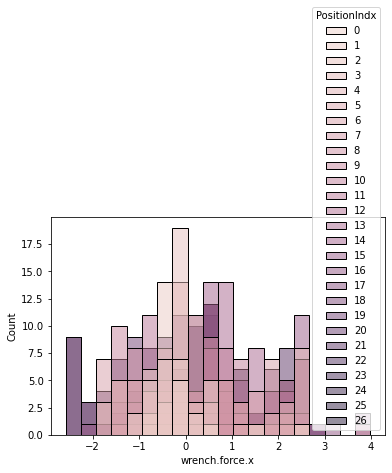

In [60]:
sns.histplot(data=all_data, x='wrench.force.x', hue='PositionIndx')

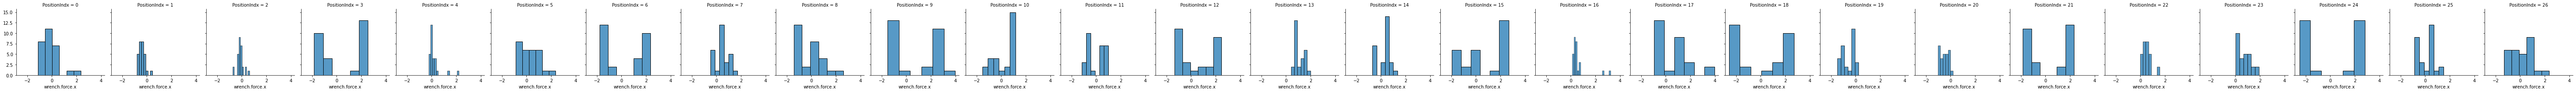

In [62]:
g = sns.FacetGrid(all_data, col='PositionIndx')
g.map(sns.histplot, 'wrench.force.x')

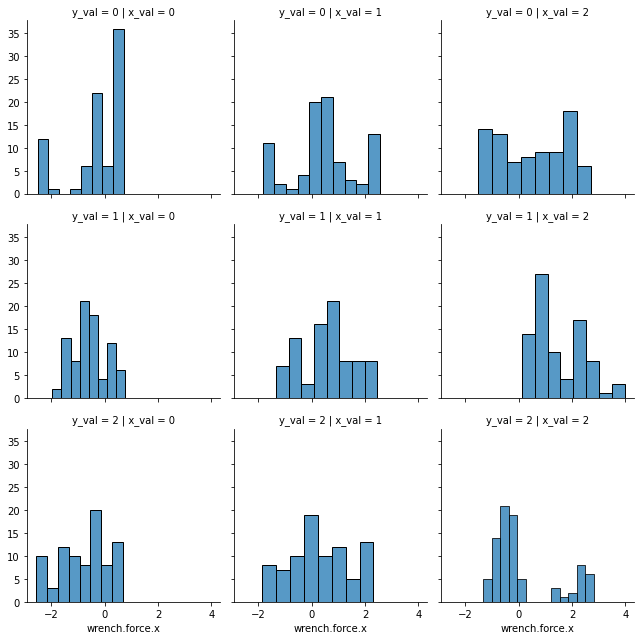

In [153]:
g = sns.FacetGrid(all_data, col='x_val', row='y_val')
g.map(sns.histplot, 'wrench.force.x')

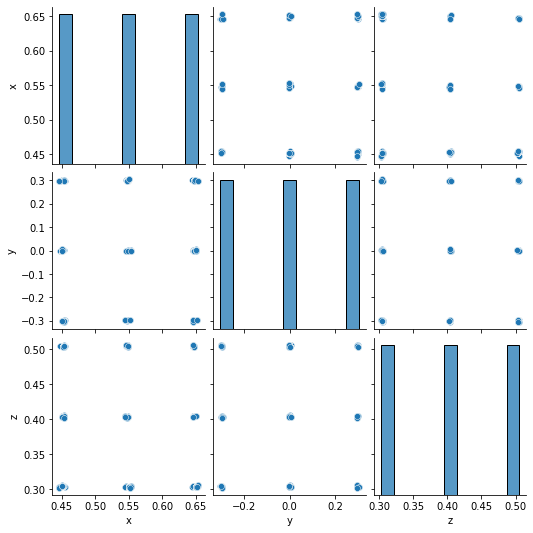

In [66]:
sns.pairplot(data=all_data, vars=['x','y','z'])

<AxesSubplot:xlabel='x', ylabel='y'>

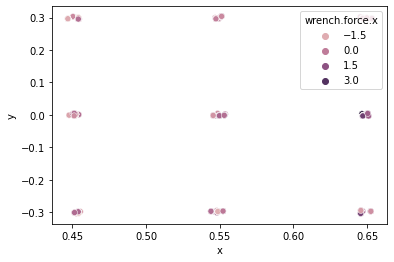

In [108]:
sns.scatterplot(data=all_data, x='x', y='y', hue='wrench.force.x',x_jitter=True, y_jitter=True)

<AxesSubplot:xlabel='PositionIndx', ylabel='wrench.force.x'>

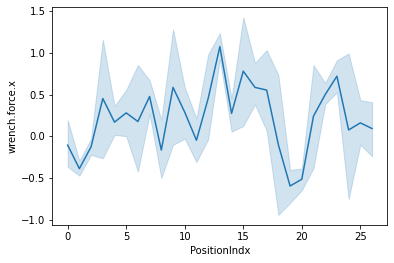

In [111]:
sns.lineplot(data=all_data,x='PositionIndx', y='wrench.force.x')

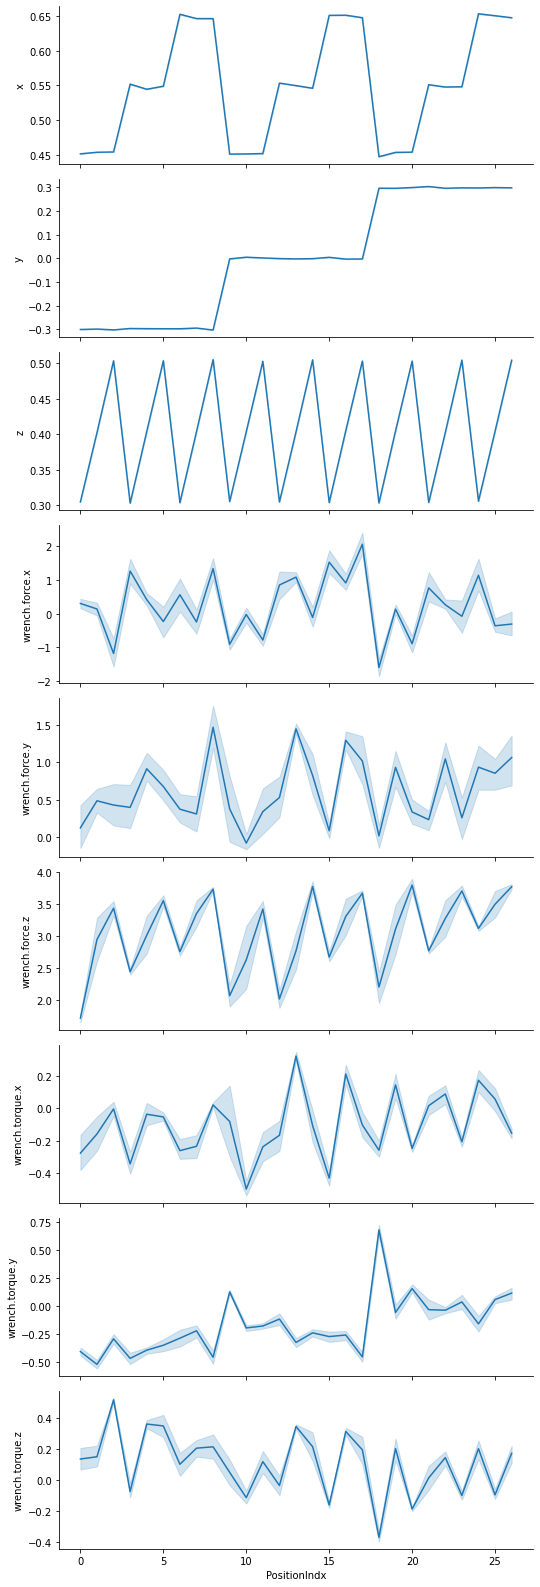

In [178]:
g = sns.PairGrid(data=all_data, 
                 x_vars=['PositionIndx'], 
                 y_vars=['x','y','z','wrench.force.x', 'wrench.force.y', 'wrench.force.z', 'wrench.torque.x', 'wrench.torque.y','wrench.torque.z'], 
                 aspect=3)
g.map(sns.lineplot)

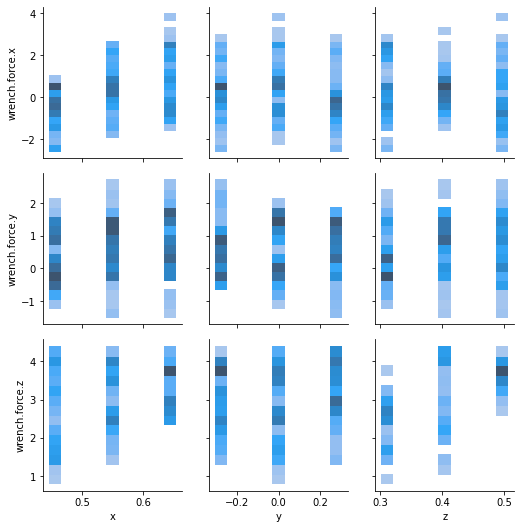

In [158]:
g = sns.PairGrid(data=all_data, 
                 x_vars=['x','y','z'],
                 y_vars=['wrench.force.x', 'wrench.force.y', 'wrench.force.z'], 
                 aspect=1)
g.map(sns.histplot)

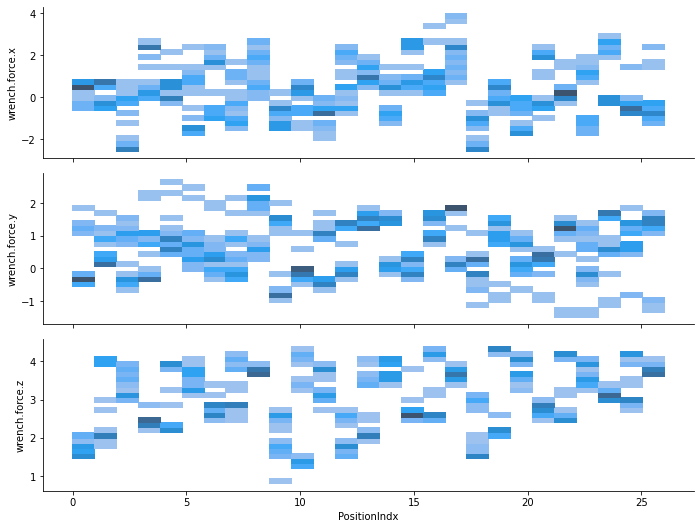

In [177]:
g = sns.PairGrid(data=all_data, 
                 x_vars=['PositionIndx'],
                 y_vars=['wrench.force.x', 'wrench.force.y', 'wrench.force.z'], 
                 aspect=4)
g.map(sns.histplot, bins=27)

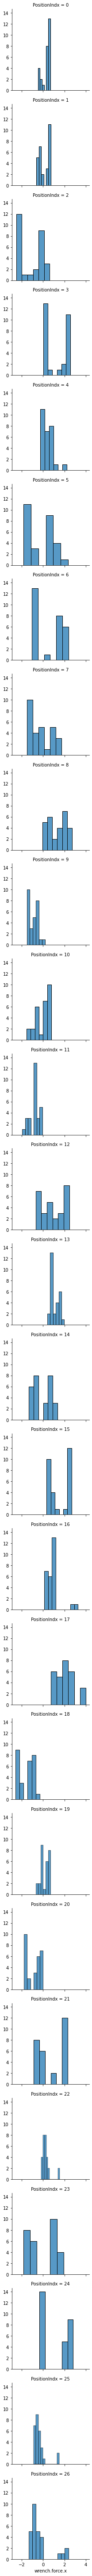

In [165]:
g = sns.FacetGrid(data=all_data, 
                  row='PositionIndx',
                  aspect=1)
g.map(sns.histplot, 'wrench.force.x')

In [181]:
x1 = [True, True, True]
x2 = [True, False, False]
x3 = [False, False]

print(np.all(x1), np.all(x2), np.all(x3))

True False False


In [184]:
os.getcwd()

'/Users/mik/Work/ros_projects/robot_stack_thanos/robot_stack_src/bubble_control/notebooks'